In [101]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings

# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


In [102]:
train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv', index_col='id')
train

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...
749995,25,69,30,Clayey,Maize,8,16,6,28-28
749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17
749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26


In [103]:
##### Shape of Train and Size
print('Train dataset has {} rows.'.format(train.shape[0]))
print('_'*50)
print('Test dataset has {} rows.'.format(test.shape[0]))

Train dataset has 750000 rows.
__________________________________________________
Test dataset has 250000 rows.


## Data Visualization:

In [104]:
target = train.columns[-1]  # Assuming the last column is the target variable
num_features = [col for col in train.select_dtypes(exclude='object').columns if col != target]
cat_features = [col for col in train.select_dtypes(include='object').columns if col != target]
print("Numerical features:", num_features)
print("Categorical features:", cat_features)
print("Target column:", target)

Numerical features: ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
Categorical features: ['Soil Type', 'Crop Type']
Target column: Fertilizer Name


# Mutual Information:

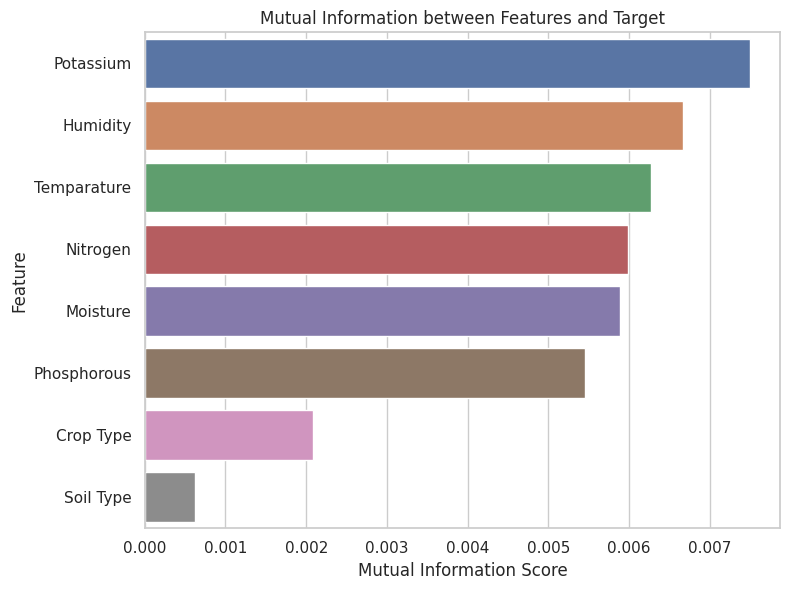

In [105]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif


# Copy the original data
X = train[num_features + cat_features].copy()

# Encode categorical features
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Target
y = train[target]

# Build discrete_features mask (True for categorical columns)
discrete_mask = [col in cat_features for col in X.columns]

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_mask, random_state=0)

# Sort and plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

mi_df = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=mi_df.values, y=mi_df.index, orient='h')
plt.title('Mutual Information between Features and Target')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Categorical Features

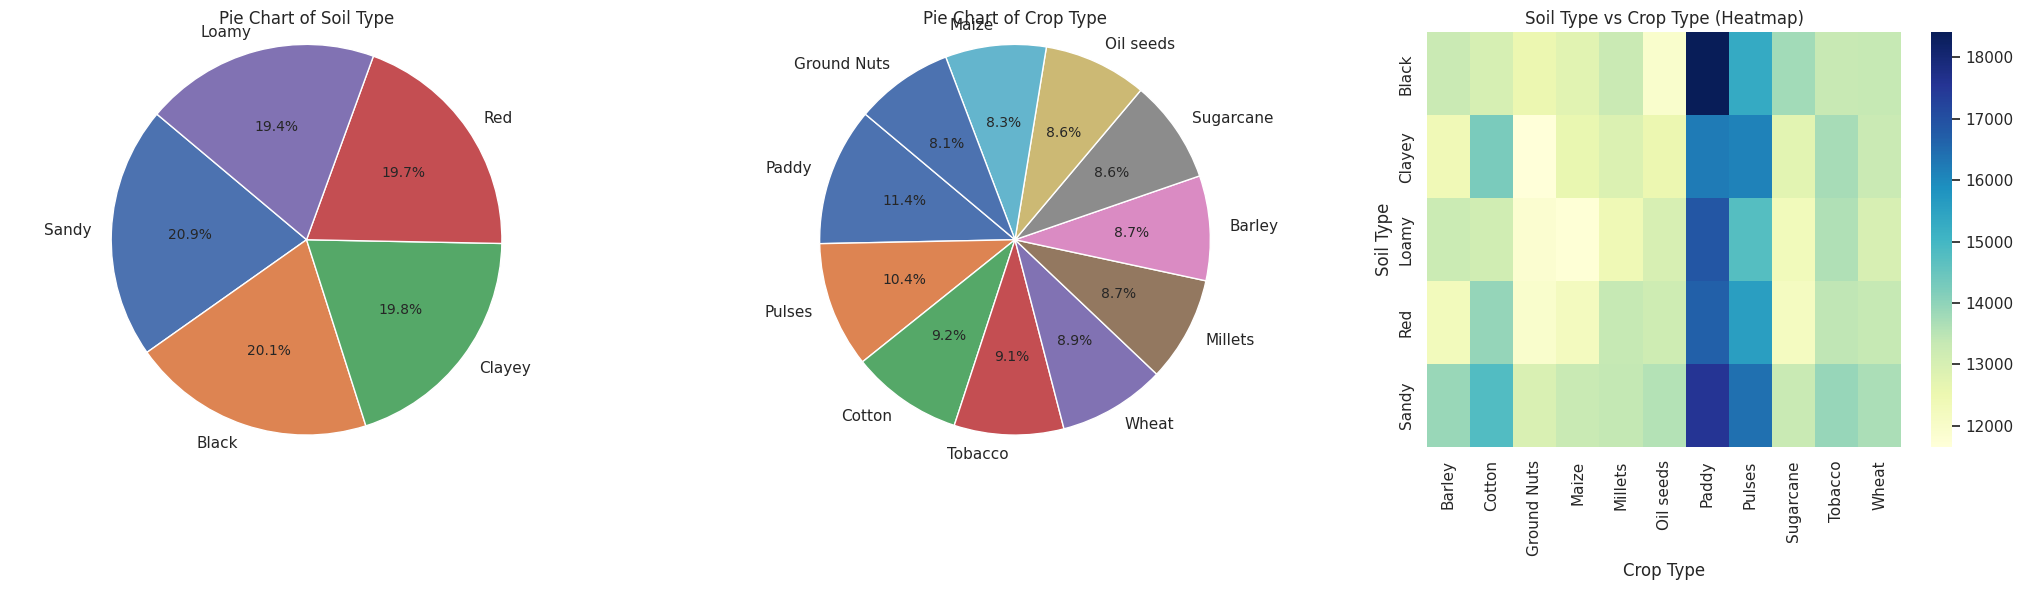

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Pie charts for categorical features
for i, col in enumerate(cat_features):
    value_counts = train[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'Pie Chart of {col}')
    axes[i].axis('equal')

cross_tab = pd.crosstab(train[cat_features[0]], train[cat_features[1]])

# Heatmap for relationship between two categorical features
sns.heatmap(cross_tab, ax=axes[2], cmap='YlGnBu', cbar=True)
axes[2].set_title(f'{cat_features[0]} vs {cat_features[1]} (Heatmap)')
axes[2].set_xlabel(cat_features[1])
axes[2].set_ylabel(cat_features[0])

plt.tight_layout()
plt.show()


# Numerical Features:

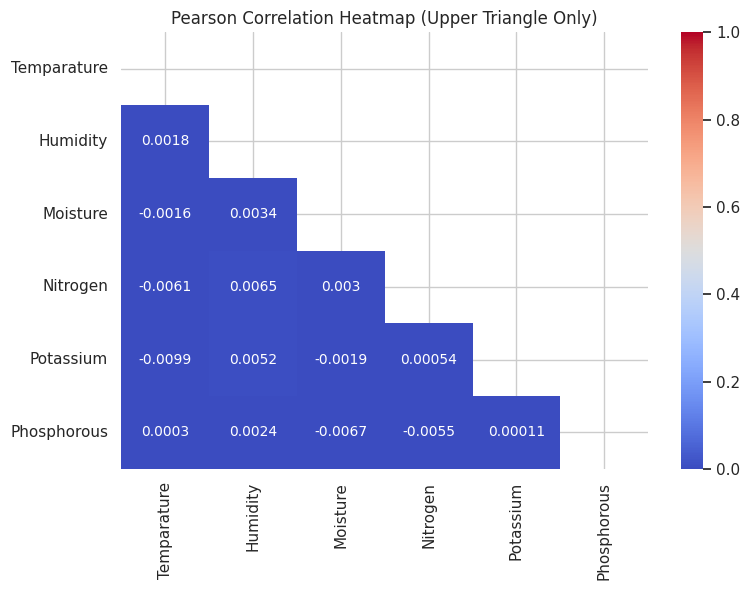

In [107]:
# Compute Pearson correlation for numerical features
pearson_corr = train[num_features].corr(method='pearson')

fig_corr, ax_corr = plt.subplots(figsize=(8, 6))

# Mask for the lower triangle
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', mask=mask, ax=ax_corr, vmin=0, vmax=1)
ax_corr.set_title('Pearson Correlation Heatmap (Upper Triangle Only)')

plt.tight_layout()
plt.show()

In [108]:
def add_npk_and_percentages(df, num_features):
    # Sum the last 3 columns in num_features to create NPK
    last3 = num_features[-3:]
    df['NPK'] = df[last3].sum(axis=1)
    # Calculate percentage for each last 3 column
    for col in last3:
        df[f'{col}_pct'] = df[col] / df['NPK'] * 100
    return df

# Example usage:
train = add_npk_and_percentages(train, num_features)
test = add_npk_and_percentages(test, num_features)
train.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,NPK,Nitrogen_pct,Potassium_pct,Phosphorous_pct
id,,,,,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,45,80.000000,8.888889,11.111111
1,27,69,65,Sandy,Millets,30,6,18,28-28,54,55.555556,11.111111,33.333333
2,29,63,32,Sandy,Millets,24,12,16,17-17-17,52,46.153846,23.076923,30.769231
3,35,62,54,Sandy,Barley,39,12,4,10-26-26,55,70.909091,21.818182,7.272727
4,35,58,43,Red,Paddy,37,2,16,DAP,55,67.272727,3.636364,29.090909


In [109]:
def get_majority_column(df):
    # Get the last 3 columns
    last3_cols = df.columns[-3:]
    
    # Get the column with the maximum value for each row and remove '_pct' suffix
    majority_col = df[last3_cols].idxmax(axis=1).str.replace('_pct', '')
    
    # Add the Majority column to the DataFrame
    df['Majority'] = majority_col
    
    # Return the DataFrame with all columns and the Majority column
    return df

# Apply the function to both train and test datasets
train = get_majority_column(train)
test = get_majority_column(test)
train

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,NPK,Nitrogen_pct,Potassium_pct,Phosphorous_pct,Majority
id,,,,,,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,45,80.000000,8.888889,11.111111,Nitrogen
1,27,69,65,Sandy,Millets,30,6,18,28-28,54,55.555556,11.111111,33.333333,Nitrogen
2,29,63,32,Sandy,Millets,24,12,16,17-17-17,52,46.153846,23.076923,30.769231,Nitrogen
3,35,62,54,Sandy,Barley,39,12,4,10-26-26,55,70.909091,21.818182,7.272727,Nitrogen
4,35,58,43,Red,Paddy,37,2,16,DAP,55,67.272727,3.636364,29.090909,Nitrogen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,25,69,30,Clayey,Maize,8,16,6,28-28,30,26.666667,53.333333,20.000000,Potassium
749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17,66,57.575758,12.121212,30.303030,Nitrogen
749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26,46,13.043478,23.913043,63.043478,Phosphorous


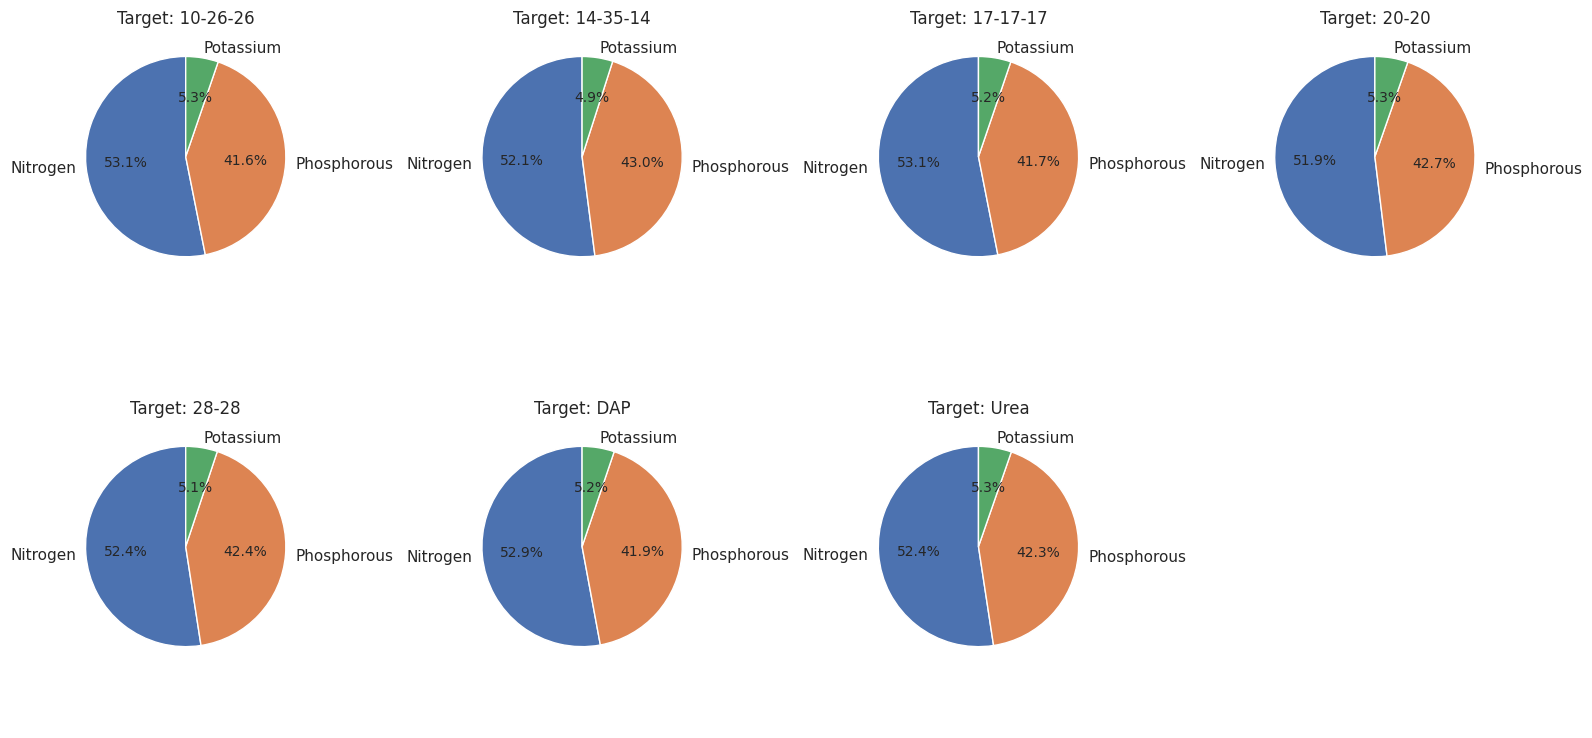

In [110]:
# Ensure column names are correct
target_column = target  # Or just 'Target' if target is a string
majority_column = 'Majority'

# Get unique Target values
unique_targets = sorted(train[target_column].unique())  # Optional: sort for consistent layout
n_targets = len(unique_targets)

# Setup: 2 rows x 4 cols
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Loop through each target and create pie chart
for i, tgt in enumerate(unique_targets):
    subset = train[train[target_column] == tgt]
    counts = subset[majority_column].value_counts()
    
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Target: {tgt}')

# Hide any unused subplots
for j in range(n_targets, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

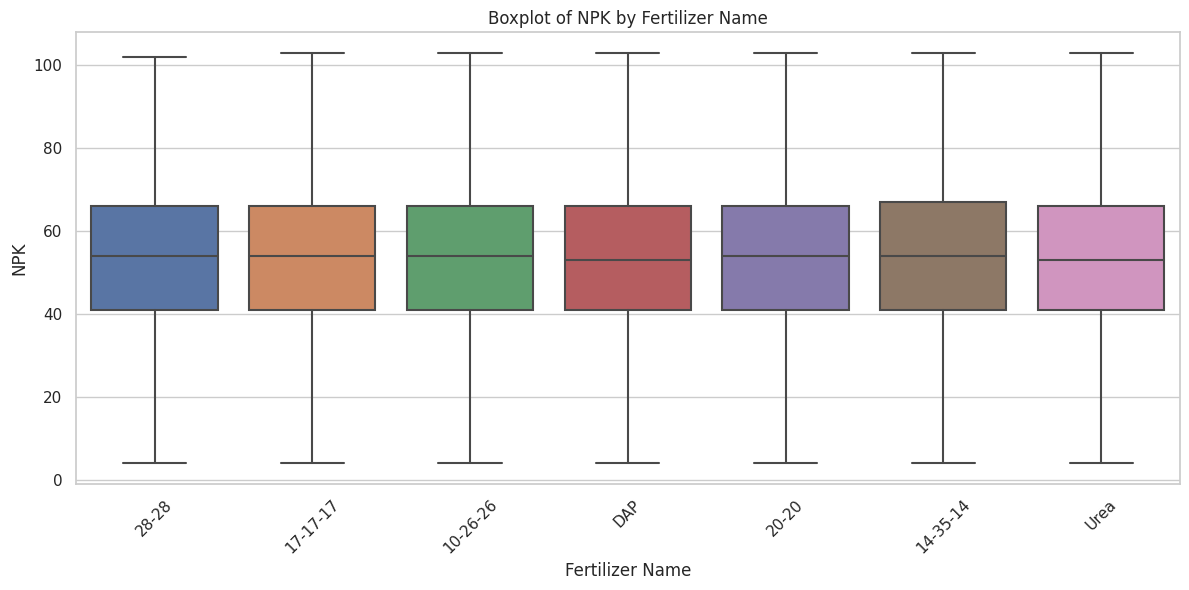

In [111]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Fertilizer Name', y='NPK', data=train)
plt.xticks(rotation=45)
plt.title('Boxplot of NPK by Fertilizer Name')
plt.tight_layout()
plt.show()

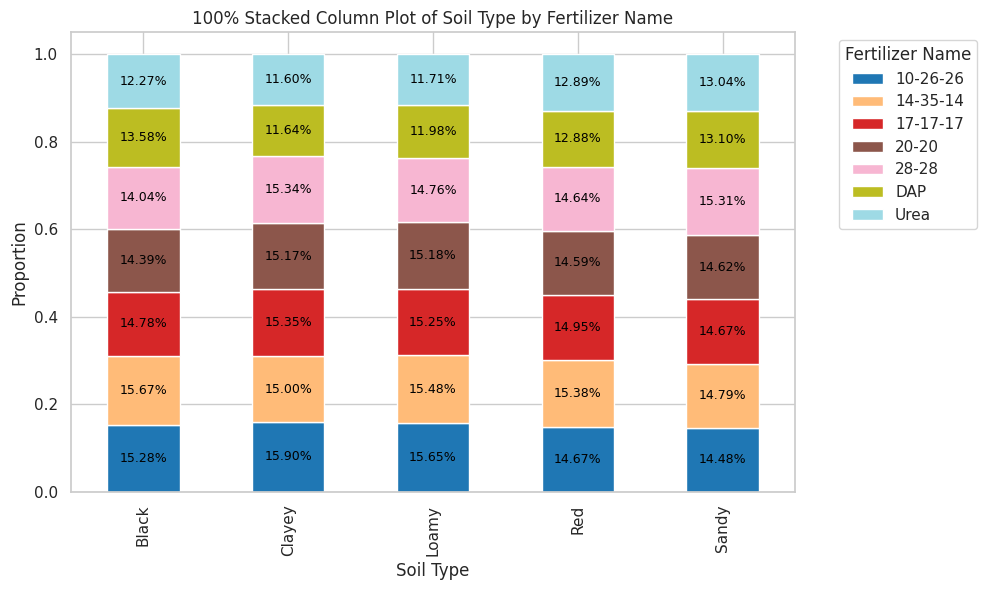

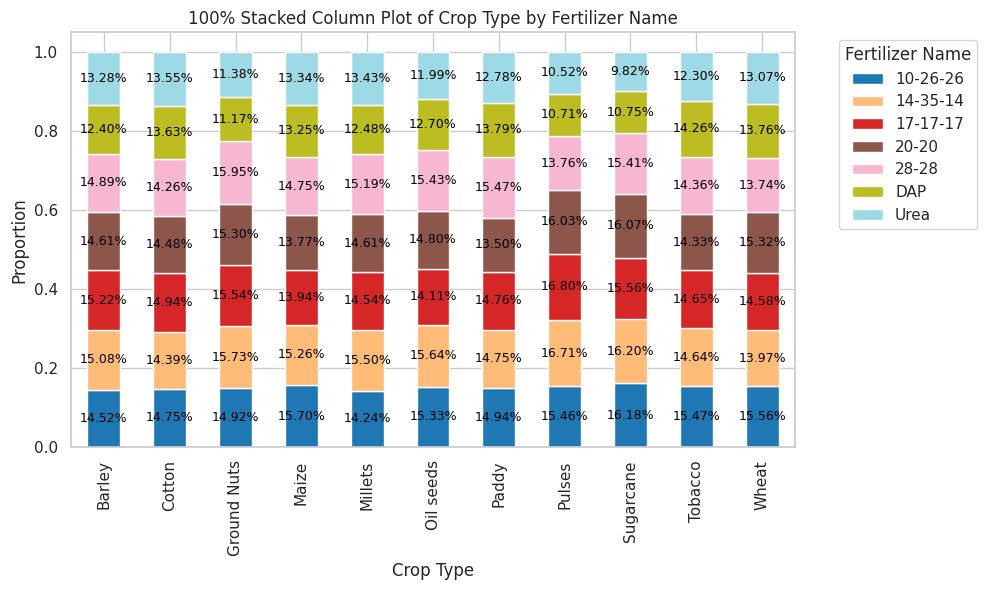

In [112]:
for col in cat_features:
    counts = train.groupby([col, target]).size().unstack(fill_value=0)
    pct = counts.div(counts.sum(axis=1), axis=0)
    ax = pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
    plt.title(f'100% Stacked Column Plot of {col} by {target}')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Add annotation
    for p in ax.patches:
        height = p.get_height()
        if height > 0.01:  # Only annotate if the bar is visible
            ax.annotate(f'{height*100:.2f}%', 
                        (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                        ha='center', va='center', fontsize=9, color='black')
    plt.show()

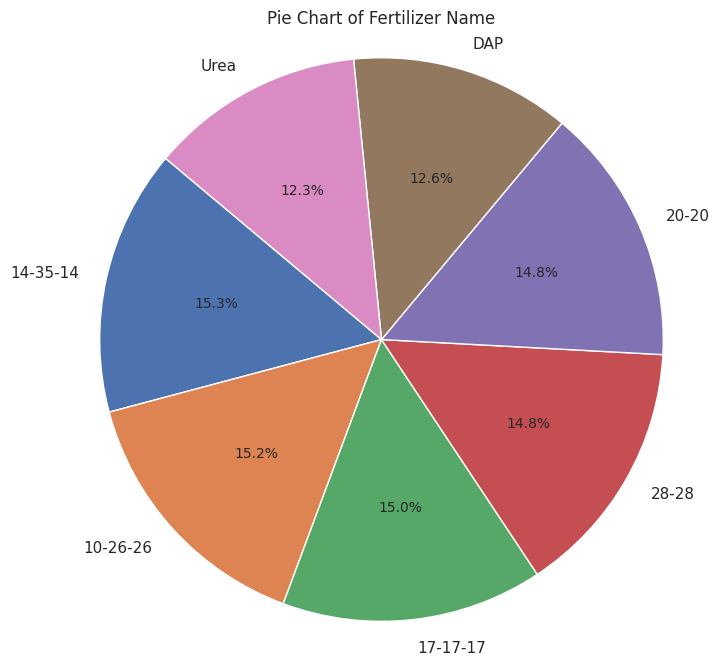

In [113]:
# Pie plot of the target variable (Fertilizer Name)
target_counts = train[target].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {target}')
plt.axis('equal')
plt.show()

In [114]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.express as px
# import pandas as pd

# # Define consistent color map
# unique_targets = train[target].unique()
# color_map = px.colors.qualitative.Plotly
# target_color_dict = {val: color_map[i % len(color_map)] for i, val in enumerate(unique_targets)}

# fig = make_subplots(
#     rows=2, cols=2,
#     subplot_titles=[
#         "Ribbon Chart - Soil Type", "Top 3 Count - Soil Type",
#         "Ribbon Chart - Crop Type", "Top 3 Count - Crop Type"
#     ],
#     horizontal_spacing=0.15,
#     vertical_spacing=0.15
# )

# for i, cat in enumerate(cat_features):
#     row = i + 1

#     freq = train.groupby([cat, target]).size().unstack(fill_value=0)
#     ranks = freq.rank(axis=1, method='min', ascending=False)
#     categories = freq.index.tolist()
#     targets = freq.columns.tolist()

#     # --- Column 1: Ribbon chart ---
#     for t in targets:
#         fig.add_trace(go.Scatter(
#             x=categories,
#             y=ranks[t],
#             mode='lines+markers',
#             name=t,
#             line_shape='spline',
#             line=dict(color=target_color_dict[t]),
#             legendgroup=t,
#             showlegend=(i == 0)  # show legend only once (row 1)
#         ), row=row, col=1)

#     # Add shaded area (cover exact x-values, ranks 1 to 3)
#     fig.add_shape(
#         type="rect",
#         xref=f"x{(row-1)*2+1}",
#         yref=f"y{(row-1)*2+1}",
#         x0=categories[0],
#         x1=categories[-1],
#         y0=1, y1=3,
#         fillcolor="LightGreen",
#         opacity=0.3,
#         layer="below",
#         line_width=0,
#         row=row, col=1
#     )

#     # --- Column 2: Top 3 Count Bar Chart ---
#     top3_counts = (ranks <= 3).sum()
#     count_df = top3_counts.reset_index()
#     count_df.columns = [target, 'Top3_Count']

#     for j in range(len(count_df)):
#         t_val = count_df[target][j]
#         fig.add_trace(go.Bar(
#             x=[t_val],
#             y=[count_df['Top3_Count'][j]],
#             name=t_val,
#             marker_color=target_color_dict[t_val],
#             legendgroup=t_val,
#             showlegend=False
#         ), row=row, col=2)

# # Final layout update


# fig.update_layout(
#     height=800,
#     title_text="Ribbon Chart and Top 3 Target Frequency by Category",
#     legend=dict(
#         x=0.47,  # Centered between the two subplots (adjust as needed)
#         y=0.5,
#         xanchor="center",
#         yanchor="middle",
#         orientation="v",  # Vertical legend
#         bgcolor="rgba(255,255,255,0.8)",
#         bordercolor="black",
#         borderwidth=1
#     )
# )



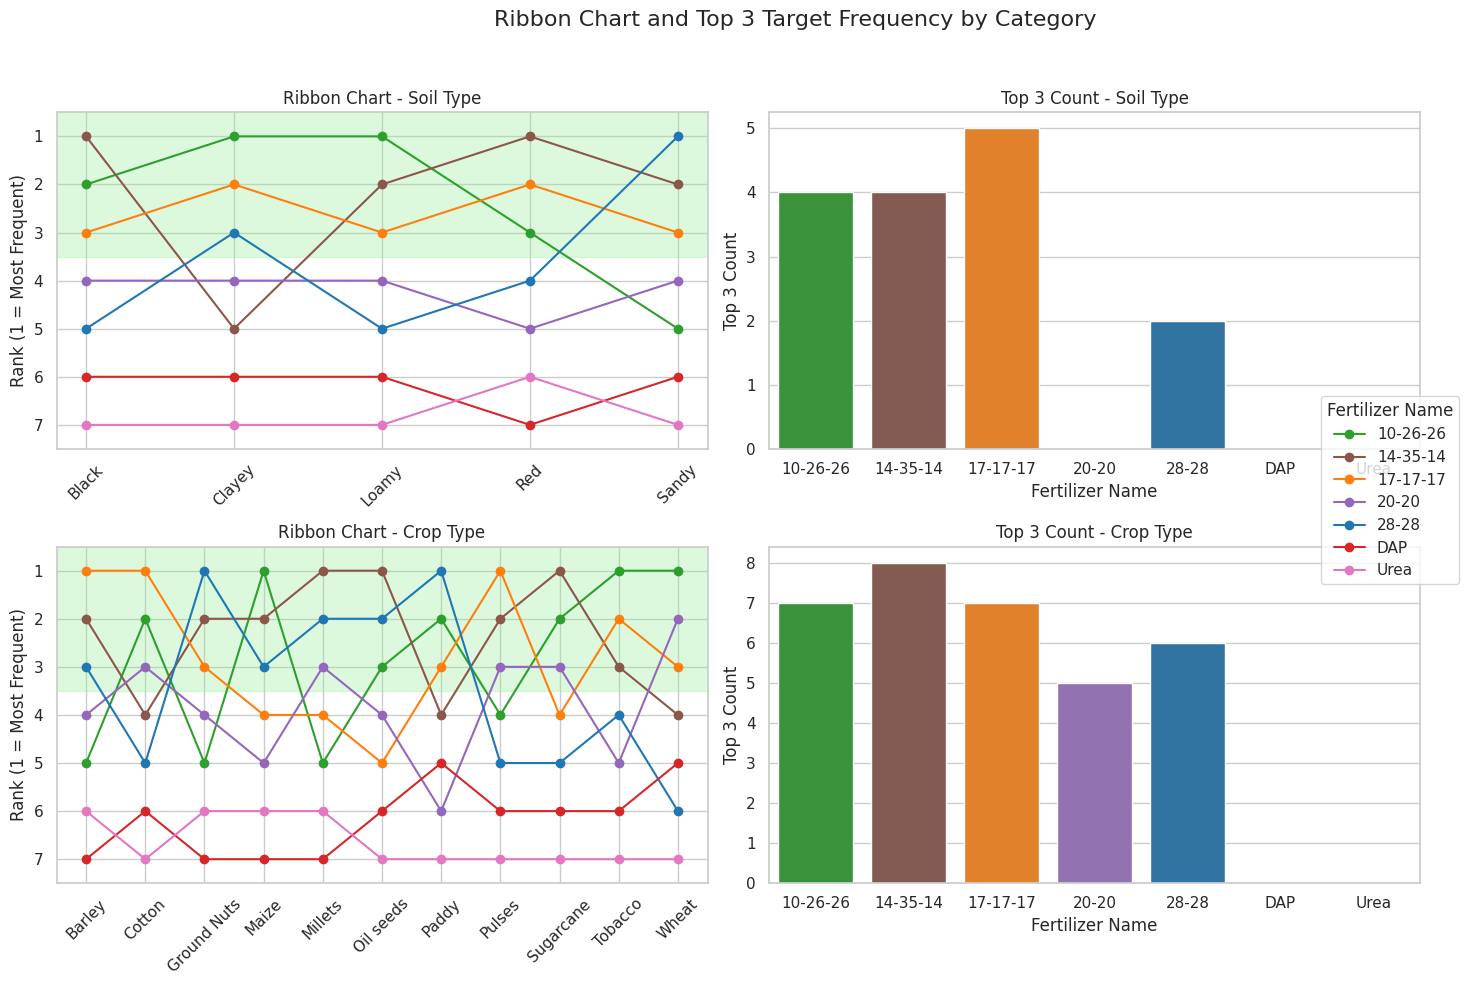

In [115]:
# Set style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})

# Color map for consistent target color
unique_targets = train[target].unique()
palette = sns.color_palette("tab10", len(unique_targets))
target_color_dict = {val: palette[i % len(palette)] for i, val in enumerate(unique_targets)}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
fig.suptitle("Ribbon Chart and Top 3 Target Frequency by Category", fontsize=16)

for i, cat in enumerate(cat_features):
    row = i  # 0 or 1
    ax_ribbon = axes[row, 0]
    ax_bar = axes[row, 1]

    # Prepare frequency and ranking
    freq = train.groupby([cat, target]).size().unstack(fill_value=0)
    ranks = freq.rank(axis=1, method='min', ascending=False)
    categories = freq.index.tolist()

    # RIBBON CHART
    for t in freq.columns:
        ax_ribbon.plot(
            categories,
            ranks[t],
            marker='o',
            label=t if row == 0 else "",
            color=target_color_dict[t]
        )

    ax_ribbon.set_title(f"Ribbon Chart - {cat}")
    ax_ribbon.set_ylabel("Rank (1 = Most Frequent)")
    ax_ribbon.set_ylim(len(freq.columns) + 0.5, 0.5)  # Reverse y-axis
    ax_ribbon.set_xticks(range(len(categories)))
    ax_ribbon.set_xticklabels(categories, rotation=45)
    ax_ribbon.axhspan(1 - 0.5, 3 + 0.5, color='lightgreen', alpha=0.3)

    # TOP 3 COUNT BARPLOT
    top3_counts = (ranks <= 3).sum().reset_index()
    top3_counts.columns = [target, 'Top3_Count']

    sns.barplot(
        x=target, y='Top3_Count',
        data=top3_counts,
        ax=ax_bar,
        palette=target_color_dict
    )
    ax_bar.set_title(f"Top 3 Count - {cat}")
    ax_bar.set_ylabel("Top 3 Count")
    ax_bar.set_xlabel(target)

# Shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.92, 0.5), borderaxespad=0.5, title=target)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [116]:
soil_freq = train.groupby('Soil Type')['Fertilizer Name'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
# Sorting values by Soil Type and Percentage in descending order
soil_freq_sorted = soil_freq.sort_values(['Soil Type', 'Percentage'], ascending=[True, False])

# Adding Rank column
soil_freq_sorted['Rank'] = soil_freq_sorted.groupby('Soil Type')['Percentage'].rank(method='first', ascending=False)
soil_top_3 = soil_freq_sorted[soil_freq_sorted['Rank'] <= 3]
soil_top_3
soil_dict = soil_top_3.groupby('Soil Type')['Fertilizer Name'].apply(list).to_dict()
soil_dict

{'Black': ['14-35-14', '10-26-26', '17-17-17'],
 'Clayey': ['10-26-26', '17-17-17', '28-28'],
 'Loamy': ['10-26-26', '14-35-14', '17-17-17'],
 'Red': ['14-35-14', '17-17-17', '10-26-26'],
 'Sandy': ['28-28', '14-35-14', '17-17-17']}

In [117]:
crop_freq = train.groupby('Crop Type')['Fertilizer Name'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
# Sorting values by Soil Type and Percentage in descending order
crop_freq_sorted = crop_freq.sort_values(['Crop Type', 'Percentage'], ascending=[True, False])

# Adding Rank column
crop_freq_sorted['Rank'] = crop_freq_sorted.groupby('Crop Type')['Percentage'].rank(method='first', ascending=False)
crop_top_3 = crop_freq_sorted[crop_freq_sorted['Rank'] <= 3]
crop_top_3
crop_dict = crop_top_3.groupby('Crop Type')['Fertilizer Name'].apply(list).to_dict()
crop_dict

{'Barley': ['17-17-17', '14-35-14', '28-28'],
 'Cotton': ['17-17-17', '10-26-26', '20-20'],
 'Ground Nuts': ['28-28', '14-35-14', '17-17-17'],
 'Maize': ['10-26-26', '14-35-14', '28-28'],
 'Millets': ['14-35-14', '28-28', '20-20'],
 'Oil seeds': ['14-35-14', '28-28', '10-26-26'],
 'Paddy': ['28-28', '10-26-26', '17-17-17'],
 'Pulses': ['17-17-17', '14-35-14', '20-20'],
 'Sugarcane': ['14-35-14', '10-26-26', '20-20'],
 'Tobacco': ['10-26-26', '17-17-17', '14-35-14'],
 'Wheat': ['10-26-26', '20-20', '17-17-17']}

In [118]:
train['Top_3_Soil'] = train['Soil Type'].map(soil_dict)
train['Top_3_Crop'] = train['Crop Type'].map(crop_dict)
train['In_Top_3_Soil'] = train.apply(
    lambda row: 'Yes' if isinstance(row['Top_3_Soil'], list) and row['Fertilizer Name'] in row['Top_3_Soil'] else 'No',
    axis=1
)

train['In_Top_3_Crop'] = train.apply(
    lambda row: 'Yes' if isinstance(row['Top_3_Crop'], list) and row['Fertilizer Name'] in row['Top_3_Crop'] else 'No',
    axis=1
)
train

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,NPK,Nitrogen_pct,Potassium_pct,Phosphorous_pct,Majority,Top_3_Soil,Top_3_Crop,In_Top_3_Soil,In_Top_3_Crop
id,,,,,,,,,,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,45,80.000000,8.888889,11.111111,Nitrogen,"[10-26-26, 17-17-17, 28-28]","[14-35-14, 10-26-26, 20-20]",Yes,No
1,27,69,65,Sandy,Millets,30,6,18,28-28,54,55.555556,11.111111,33.333333,Nitrogen,"[28-28, 14-35-14, 17-17-17]","[14-35-14, 28-28, 20-20]",Yes,Yes
2,29,63,32,Sandy,Millets,24,12,16,17-17-17,52,46.153846,23.076923,30.769231,Nitrogen,"[28-28, 14-35-14, 17-17-17]","[14-35-14, 28-28, 20-20]",Yes,No
3,35,62,54,Sandy,Barley,39,12,4,10-26-26,55,70.909091,21.818182,7.272727,Nitrogen,"[28-28, 14-35-14, 17-17-17]","[17-17-17, 14-35-14, 28-28]",No,No
4,35,58,43,Red,Paddy,37,2,16,DAP,55,67.272727,3.636364,29.090909,Nitrogen,"[14-35-14, 17-17-17, 10-26-26]","[28-28, 10-26-26, 17-17-17]",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,25,69,30,Clayey,Maize,8,16,6,28-28,30,26.666667,53.333333,20.000000,Potassium,"[10-26-26, 17-17-17, 28-28]","[10-26-26, 14-35-14, 28-28]",Yes,Yes
749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17,66,57.575758,12.121212,30.303030,Nitrogen,"[10-26-26, 14-35-14, 17-17-17]","[14-35-14, 10-26-26, 20-20]",Yes,No
749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26,46,13.043478,23.913043,63.043478,Phosphorous,"[28-28, 14-35-14, 17-17-17]","[28-28, 14-35-14, 17-17-17]",No,No


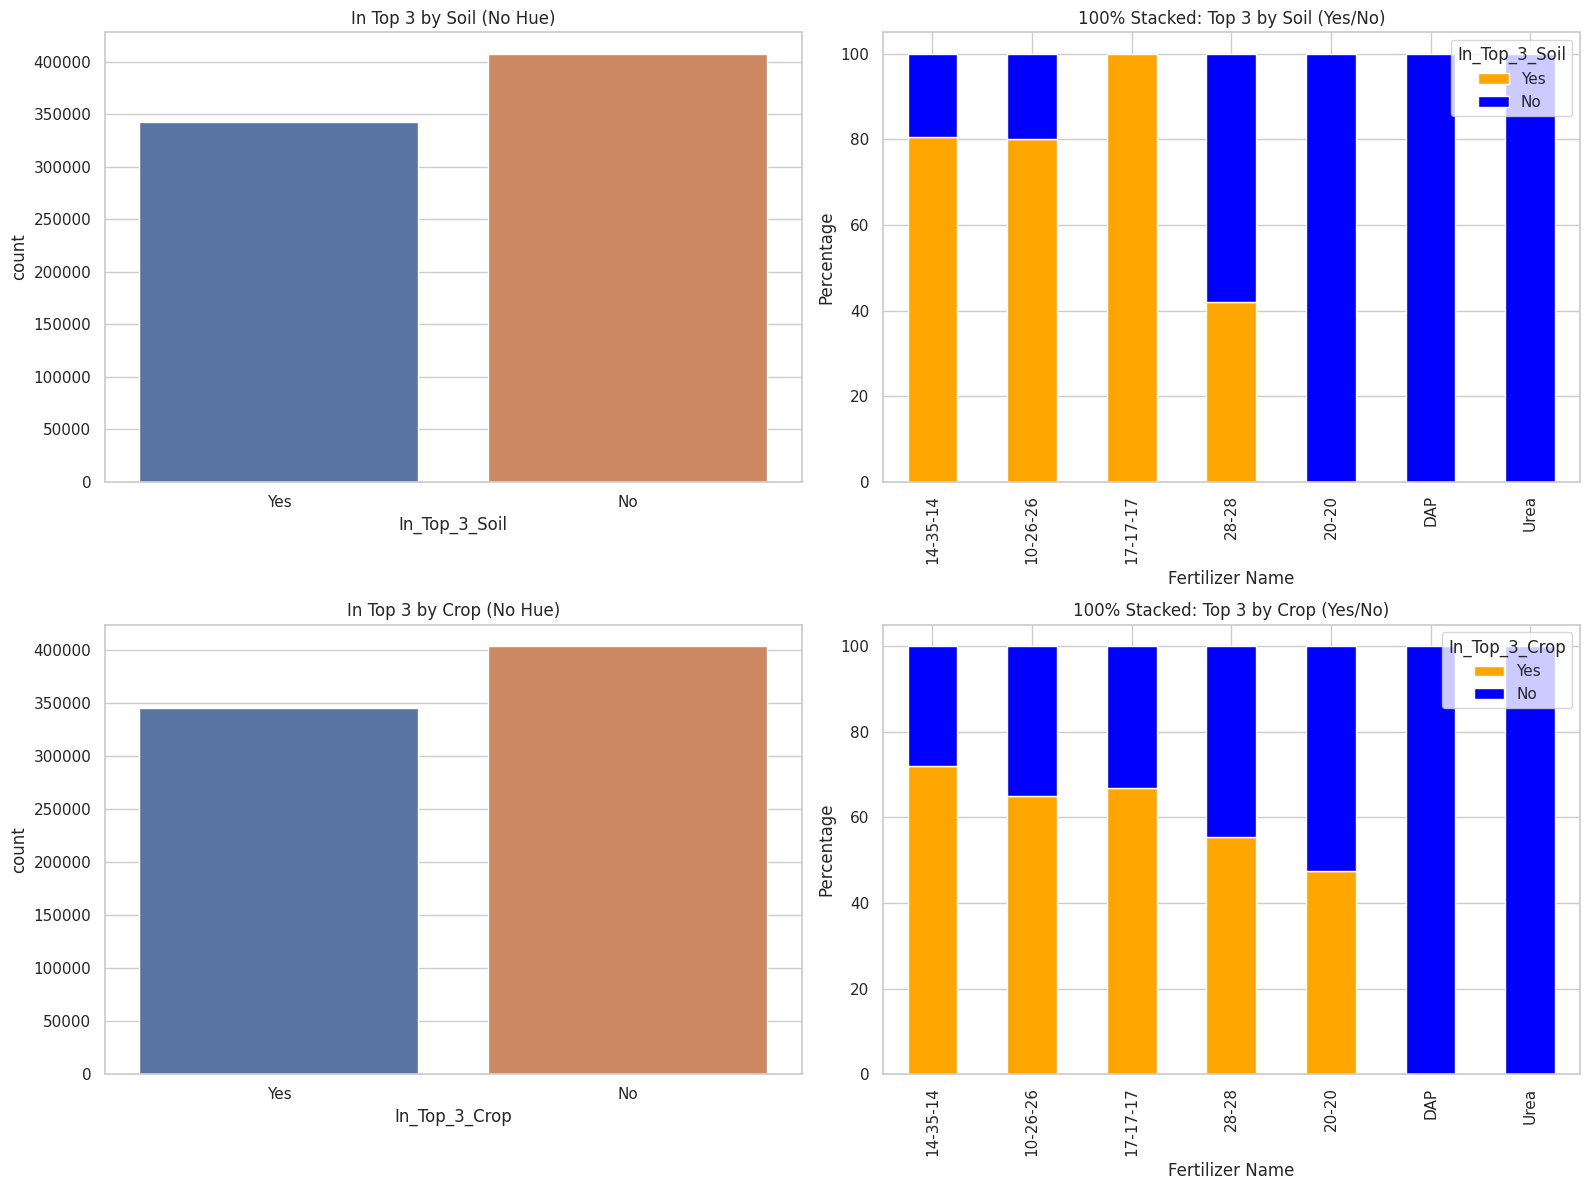

In [119]:
# Set up 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define fertilizer order (optional, for consistent sorting)
fertilizer_order = train['Fertilizer Name'].value_counts().index.tolist()

# Row 1, Col 1 — In_Top_3_Soil (no hue)
sns.countplot(x='In_Top_3_Soil', data=train, order=['Yes', 'No'], ax=axes[0, 0])
axes[0, 0].set_title('In Top 3 by Soil (No Hue)')

# Row 1, Col 2 — 100% stacked by Fertilizer Name for In_Top_3_Soil
soil_pivot = (
    train.groupby(['Fertilizer Name', 'In_Top_3_Soil']).size()
    .unstack(fill_value=0)
    .reindex(fertilizer_order)
)
soil_pct = soil_pivot.div(soil_pivot.sum(axis=1), axis=0) * 100
soil_pct[['Yes', 'No']].plot(
    kind='bar',
    stacked=True,
    ax=axes[0, 1],
    color=['orange', 'blue']
)
axes[0, 1].set_title('100% Stacked: Top 3 by Soil (Yes/No)')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(title='In_Top_3_Soil', loc='upper right')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)

# Row 2, Col 1 — In_Top_3_Crop (no hue)
sns.countplot(x='In_Top_3_Crop', data=train, order=['Yes', 'No'], ax=axes[1, 0])
axes[1, 0].set_title('In Top 3 by Crop (No Hue)')

# Row 2, Col 2 — 100% stacked by Fertilizer Name for In_Top_3_Crop
crop_pivot = (
    train.groupby(['Fertilizer Name', 'In_Top_3_Crop']).size()
    .unstack(fill_value=0)
    .reindex(fertilizer_order)
)
crop_pct = crop_pivot.div(crop_pivot.sum(axis=1), axis=0) * 100
crop_pct[['Yes', 'No']].plot(
    kind='bar',
    stacked=True,
    ax=axes[1, 1],
    color=['orange', 'blue']
)
axes[1, 1].set_title('100% Stacked: Top 3 by Crop (Yes/No)')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].legend(title='In_Top_3_Crop', loc='upper right')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

In [120]:
train[train['In_Top_3_Soil'] == 'No']

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,NPK,Nitrogen_pct,Potassium_pct,Phosphorous_pct,Majority,Top_3_Soil,Top_3_Crop,In_Top_3_Soil,In_Top_3_Crop
id,,,,,,,,,,,,,,,,,,
3,35,62,54,Sandy,Barley,39,12,4,10-26-26,55,70.909091,21.818182,7.272727,Nitrogen,"[28-28, 14-35-14, 17-17-17]","[17-17-17, 14-35-14, 28-28]",No,No
4,35,58,43,Red,Paddy,37,2,16,DAP,55,67.272727,3.636364,29.090909,Nitrogen,"[14-35-14, 17-17-17, 10-26-26]","[28-28, 10-26-26, 17-17-17]",No,No
5,30,59,29,Red,Pulses,10,0,9,20-20,19,52.631579,0.000000,47.368421,Nitrogen,"[14-35-14, 17-17-17, 10-26-26]","[17-17-17, 14-35-14, 20-20]",No,Yes
9,28,50,35,Red,Tobacco,25,12,16,20-20,53,47.169811,22.641509,30.188679,Nitrogen,"[14-35-14, 17-17-17, 10-26-26]","[10-26-26, 17-17-17, 14-35-14]",No,No
11,38,60,27,Clayey,Sugarcane,34,19,12,20-20,65,52.307692,29.230769,18.461538,Nitrogen,"[10-26-26, 17-17-17, 28-28]","[14-35-14, 10-26-26, 20-20]",No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749992,37,54,53,Red,Wheat,14,4,18,20-20,36,38.888889,11.111111,50.000000,Phosphorous,"[14-35-14, 17-17-17, 10-26-26]","[10-26-26, 20-20, 17-17-17]",No,Yes
749993,28,54,55,Black,Tobacco,14,2,35,Urea,51,27.450980,3.921569,68.627451,Phosphorous,"[14-35-14, 10-26-26, 17-17-17]","[10-26-26, 17-17-17, 14-35-14]",No,No
749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26,46,13.043478,23.913043,63.043478,Phosphorous,"[28-28, 14-35-14, 17-17-17]","[28-28, 14-35-14, 17-17-17]",No,No


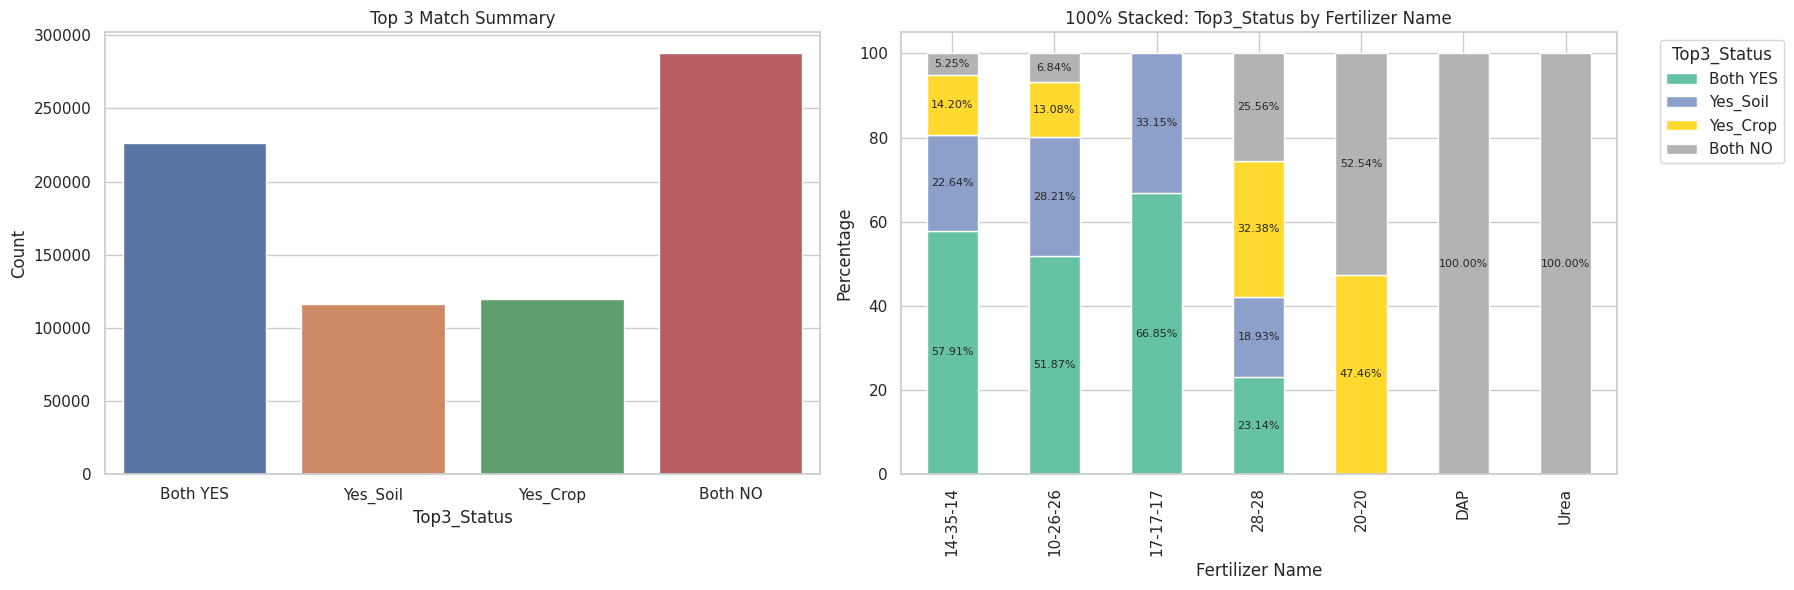

In [121]:
def summarize_top3(row):
    if row['In_Top_3_Soil'] == 'Yes' and row['In_Top_3_Crop'] == 'Yes':
        return 'Both YES'
    elif row['In_Top_3_Soil'] == 'Yes':
        return 'Yes_Soil'
    elif row['In_Top_3_Crop'] == 'Yes':
        return 'Yes_Crop'
    else:
        return 'Both NO'

train['Top3_Status'] = train.apply(summarize_top3, axis=1)# Set up 1 row, 2 columns

# Set up 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Consistent order
status_order = ['Both YES', 'Yes_Soil', 'Yes_Crop', 'Both NO']
fertilizer_order = train['Fertilizer Name'].value_counts().index.tolist()

# Plot 1: Basic countplot
sns.countplot(x='Top3_Status', data=train, order=status_order, ax=axes[0])
axes[0].set_title('Top 3 Match Summary')
axes[0].set_ylabel('Count')

# Plot 2: 100% stacked bar (Fertilizer Name x Top3_Status)
pivot = (
    train.groupby(['Fertilizer Name', 'Top3_Status']).size()
    .unstack(fill_value=0)
    .reindex(fertilizer_order)
)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct[status_order]  # Ensure column order

# Plot stacked bar
pivot_pct.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    colormap='Set2'
)

# Annotation
for i, (index, row) in enumerate(pivot_pct.iterrows()):
    cum_height = 0
    for status in status_order:
        value = row[status]
        if value > 0:
            axes[1].text(
                i, 
                cum_height + value / 2,
                f"{value:.2f}%",
                ha='center',
                va='center',
                fontsize=8
            )
            cum_height += value

# Formatting
axes[1].set_title('100% Stacked: Top3_Status by Fertilizer Name')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('Fertilizer Name')
axes[1].legend(title='Top3_Status', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

plt.show()

In [122]:
yes = train[train['Top3_Status'] != 'Both NO']
yes[['Fertilizer Name','Top_3_Soil','Top_3_Crop']]
def get_score(fert_name, top_list):
    try:
        idx = top_list.index(fert_name)
        return 3 - idx  # 0 → 3, 1 → 2, 2 → 1
    except (ValueError, TypeError):
        return 0
yes = yes.copy()
yes.loc[:, 'Soil_Score'] = yes.apply(lambda row: get_score(row['Fertilizer Name'], row['Top_3_Soil']), axis=1)
yes.loc[:, 'Crop_Score'] = yes.apply(lambda row: get_score(row['Fertilizer Name'], row['Top_3_Crop']), axis=1)

yes

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,NPK,...,Potassium_pct,Phosphorous_pct,Majority,Top_3_Soil,Top_3_Crop,In_Top_3_Soil,In_Top_3_Crop,Top3_Status,Soil_Score,Crop_Score
id,,,,,,,,,,,,,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,45,...,8.888889,11.111111,Nitrogen,"[10-26-26, 17-17-17, 28-28]","[14-35-14, 10-26-26, 20-20]",Yes,No,Yes_Soil,1,0
1,27,69,65,Sandy,Millets,30,6,18,28-28,54,...,11.111111,33.333333,Nitrogen,"[28-28, 14-35-14, 17-17-17]","[14-35-14, 28-28, 20-20]",Yes,Yes,Both YES,3,2
2,29,63,32,Sandy,Millets,24,12,16,17-17-17,52,...,23.076923,30.769231,Nitrogen,"[28-28, 14-35-14, 17-17-17]","[14-35-14, 28-28, 20-20]",Yes,No,Yes_Soil,1,0
5,30,59,29,Red,Pulses,10,0,9,20-20,19,...,0.000000,47.368421,Nitrogen,"[14-35-14, 17-17-17, 10-26-26]","[17-17-17, 14-35-14, 20-20]",No,Yes,Yes_Crop,0,1
6,27,62,53,Sandy,Paddy,26,15,22,28-28,63,...,23.809524,34.920635,Nitrogen,"[28-28, 14-35-14, 17-17-17]","[28-28, 10-26-26, 17-17-17]",Yes,Yes,Both YES,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749992,37,54,53,Red,Wheat,14,4,18,20-20,36,...,11.111111,50.000000,Phosphorous,"[14-35-14, 17-17-17, 10-26-26]","[10-26-26, 20-20, 17-17-17]",No,Yes,Yes_Crop,0,2
749994,32,68,36,Black,Ground Nuts,32,18,16,14-35-14,66,...,27.272727,24.242424,Nitrogen,"[14-35-14, 10-26-26, 17-17-17]","[28-28, 14-35-14, 17-17-17]",Yes,Yes,Both YES,3,2
749995,25,69,30,Clayey,Maize,8,16,6,28-28,30,...,53.333333,20.000000,Potassium,"[10-26-26, 17-17-17, 28-28]","[10-26-26, 14-35-14, 28-28]",Yes,Yes,Both YES,1,1


<Axes: xlabel='Score', ylabel='count'>

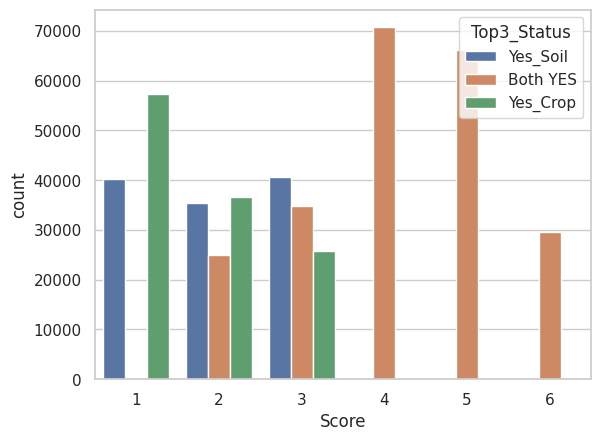

In [124]:
yes['Score'] = yes['Soil_Score'] + yes['Crop_Score']
sns.countplot(x='Score',data=yes,hue='Top3_Status')